In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

#### 0. Przygotowanie Danych

In [3]:
test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv', index_col=0)
train_df = pd.read_csv('data/UNSW_NB15_training-set.csv', index_col=0)
df_features = pd.read_csv('data/UNSW_NB15_features.csv', encoding='cp1252', index_col=0)

Ujednolicenie nazw pomiędzy ramkami danych

In [6]:
df_features.Name = list(map(lambda x : x.lower(), df_features.Name))
df_features.loc[:, 'Type '] = list(map(lambda x : x.lower(), df_features.loc[:, 'Type ']))
df_features.loc[df_features.Name == 'ct_src_ ltm', 'Name'] = 'ct_src_ltm'
df_features.loc[df_features.Name == 'res_bdy_len', 'Name'] = 'response_body_len'
df_features.loc[df_features.Name == 'smeansz', 'Name'] = 'smean'
df_features.loc[df_features.Name == 'dmeansz', 'Name'] = 'dmean'
df_features.loc[df_features.Name == 'sintpkt', 'Name'] = 'sinpkt'
df_features.loc[df_features.Name == 'dintpkt', 'Name'] = 'dinpkt'

Podział danych na treningowe, testowe i walidacyjne

In [7]:
val_df, test_df = train_test_split(test_df, random_state=710, test_size=0.3)

In [8]:
X_train = train_df.drop(columns=['label', 'attack_cat'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label', 'attack_cat'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label', 'attack_cat'])
y_test = test_df['label']

In [9]:
numeric_columns = X_train.select_dtypes('number').columns
categorical_columns = X_train.select_dtypes('object').columns

#### 1. Feature Engineering

Sprawdźmy czy są jakieś silnie skorelowane zmienne.

Dla modeli drzewiastych to raczej nie ma większego znaczenia, ale będziemy też sprawdzać skuteczność regresji logistycznej i tam usunięcie takich zmiennych może pomóc.

<AxesSubplot:>

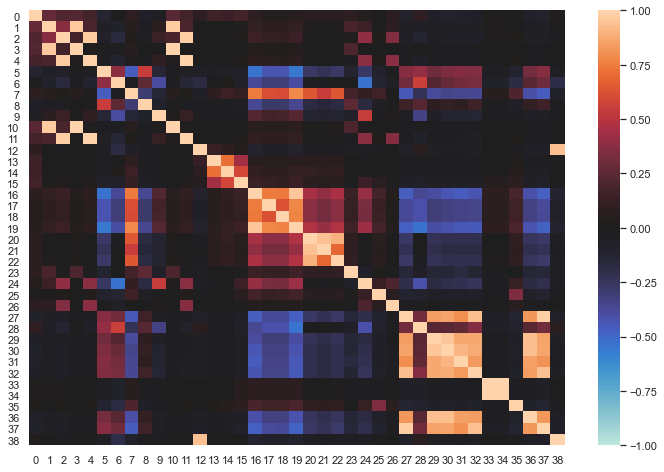

In [92]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), 
                vmin=-1, vmax=1, 
                xticklabels=np.arange(0, numeric_columns.shape[0]), # liczby dla czytelności
                yticklabels=np.arange(0, numeric_columns.shape[0]),
                cmap="icefire"
            )

Sprawdźmy feature importance poszczególnych zmiennych. Wykorzystamy do tego funkcję ```mutual_info_classif```.

Na wykresie przedstawimy 10 najbardziej predykcyjnych atrybutów.

Informacji zawartych w ```mi``` będziemy później często używać do ogarniczania liczby atrybutów.

Powinniśmy raczej patrzeć na współczynnik gini, ale na razie wykorzystami tę funkcję.

In [52]:
mi = mutual_info_classif(X_train[numeric_columns], y_train)
mi = pd.Series(data = mi, index = numeric_columns)

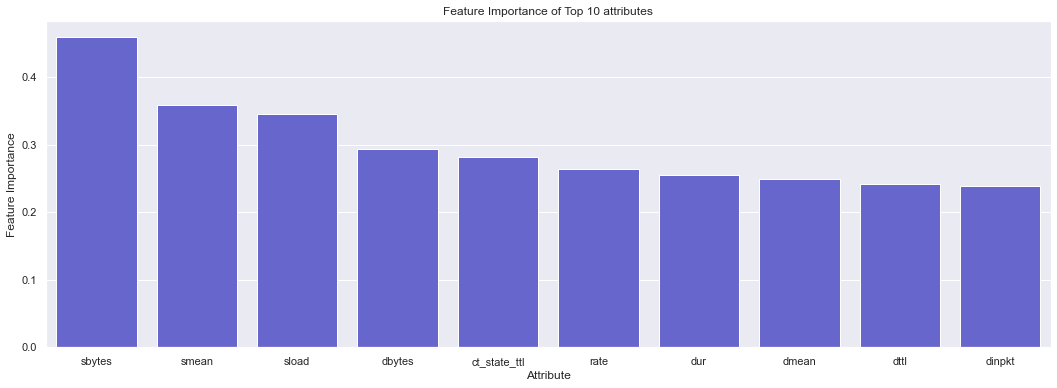

In [255]:
plt.figure(figsize=(18, 6))
mi = mi.sort_values(ascending=False)
sns.barplot(x = mi[:10].index, y = mi[:10].values, color='#5555dd')
plt.title("Feature Importance of Top 10 attributes")
plt.xlabel("Attribute")
plt.ylabel("Feature Importance")
plt.show()


Poniżej mamy funkcję do usuwania zmiennych silnie skorelowanych w lepszy niż losowy sposób.

To znaczy staramy się wpierw usuwać te najmniej znaczące.

In [256]:
def remove_correlated_features(X, y = None, threshold = 0.65, features=numeric_columns, mi = None, corr_df = None):
    # at least one of 'y' and 'mi' must be not None
    assert(y is not None or mi is not None)
    if mi is None:
        mi = pd.Series(data = mutual_info_classif(X[features], y), index=features)
    if corr_df is None:
        corr_df = X.corr()

    # convert to an easier to use data frame
    corr_df = corr_df.melt(ignore_index=False).\
        reset_index(drop=False).\
        rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})

    # we look for all pairs of (different) features that are highly correlated
    corr_df = corr_df[
                (np.abs(corr_df['Corr']) > threshold) & 
                (corr_df['Var 1'] != corr_df['Var 2'])
        ].\
        sort_values(by='Corr', ascending=False)

    removed_features = set()

    # ALGORYTM 1
    # idziemy od najbardziej skorelowanych atrybutów i usuwamy ten mniej ważny
    # jeśli któryś już był wcześniej usunięty idziemy dalej

    # 
    # for _, row in corr_df.iterrows():
    #     var_1 = row['Var 1']
    #     var_2 = row['Var 2']
    #     if (var_1 in removed_features or var_2 in removed_features):
    #         continue # if a column is already to be removed do not remove any additional ones
    #     fi_1 = mi[var_1]
    #     fi_2 = mi[var_2]
    #     if (fi_2 < fi_1): removed_features.add(var_2)
    #     else: removed_features.add(var_1)

    # ALGORYTM 2
    # usuwamy atrybuty od najmniej ważnych tak długo jak są pary silnie skorelowane

    mi = mi.sort_values()
    correlated_features = set(corr_df['Var 1']).union(set(corr_df['Var 2']))

    i = 0 
    while corr_df.shape[0] > 0 and i < mi.shape[0]:
        feature = mi.index[i]
        i += 1
        if feature not in correlated_features:
            continue
        correlated_features.remove(feature)
        removed_features.add(feature)
        corr_df = corr_df[(corr_df['Var 1'] != feature) & (corr_df['Var 2'] != feature)]
    

    return X.drop(list(removed_features), axis=1), list(removed_features)
    

Sprawdźmy jak wygląda korelacja po usunięciu najbardziej skorelowanych

<AxesSubplot:>

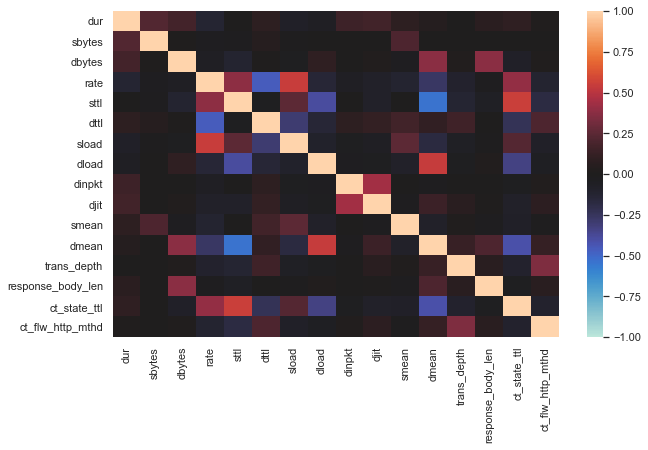

In [217]:
plt.figure(figsize=(10, 6))
X_train_reduced = remove_correlated_features(X_train, mi=mi)[0]
uncorrelated_columns = X_train_reduced.columns # to się przyda na potem
sns.heatmap(X_train_reduced.corr(), vmin=-1, vmax=1, cmap="icefire")

#### 2. Przygotowanie Pipelineów

Poniżej definiujemy kilka klas, które używamy przy budowaniu naszych Pipelineów.

In [148]:
# ta klasa nie jest używana, ale w paru przypadkach może być wygodniejsza do użycia niż 
# ColumnSelectorTransformer, więc póki co ją zostawiam
class ColumnDropperTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)

    def fit(self, X, y=None):
        return self

class ColumnSelectorTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X[self.columns]

    def fit(self, X, y=None):
        return self

# lepiej po prostu używać wyniku remove_correlated_columns w columns_to_use 
# klasa do wyrzucania zmiennych silnie skorelowanych
class CorrelatedFeatureDropperTransformer():
    def __init__(self, mi = None, features = None):
        self.mi = mi                # if not provided it will be calculated (however it often takes a long time)
        self.features = features    # if not None completly skips fitting to the provided data

    def transform(self, X, y=None):
        return X.drop(np.intersect1d(X.columns, self.features), axis=1)

    def fit(self, X, y=None):
        assert(self.mi is not None or y is not None)
        if (self.features is not None): 
            return self
        if (self.mi is None):
            self.mi = pd.Series(mutual_info_classif(X, y), index=X.columns)
        self.features = remove_correlated_features(X, mi=self.mi)[1]
        return self



In [155]:
numeric_transformer = Pipeline(
                        steps=[
                            # nie ma u nas braków danych, ale można zastanowić się jak byśmy do
                            # nich podeszli, gdyby jednak jakieś były
                            # ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                            ("scaler", StandardScaler())
                        ]
                      )

# w kategorycznych też można pomyśleć co jeśli byłby null
categorical_transformer = OneHotEncoder(drop='first')

def create_column_transformer(columns_to_use):
    numeric_columns_to_use = np.intersect1d(columns_to_use, numeric_columns)
    categorical_columns_to_use = np.intersect1d(columns_to_use, categorical_columns)
    
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_columns_to_use),
            ("cat", categorical_transformer, categorical_columns_to_use),
        ]
    )

In [253]:
# columns_to_use = ['ct_dst_sport_ltm', 'sttl', 'dload', 'ct_state_ttl', 'dmean']
columns_to_use = np.intersect1d(uncorrelated_columns, mi.sort_values(ascending=False).index[:6])

#### 2.1 Przygotowanie Modeli

In [220]:
preprocessor = Pipeline(
    steps=[
        ("column_selector", ColumnSelectorTransformer(columns=columns_to_use)),
        ("column_transformer", create_column_transformer(columns_to_use)),
    ]
)

rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=710))
    ]
)

xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=710, eval_metric='logloss', use_label_encoder=False))
    ]
)

adb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", AdaBoostClassifier(random_state=710))
    ]
)

lr_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=710))
    ]
)

#### 3. Ewaluacja Modeli

Sprawdzimy wstępną skuteczność kilku modeli. Porównamy je i ocenimy, który najlepiej się sprawdza.

Przede wszystkim sprawdzimy RandomForrestClassifier oraz XGBClassifier, ale także AdaBoost oraz LinearRegression

In [236]:
# funkcja pomocnicza do ewaluacji modelu

def statistics_classification(y, y_pred, y_pred_proba):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    axes[0].set_title('ROC curve')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    # plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not an attack)', '1 (Attack)'], yticklabels=['0 (Not an attack)', '1 (Attack)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix')
    plt.show()

    # display metrics
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')

fitted


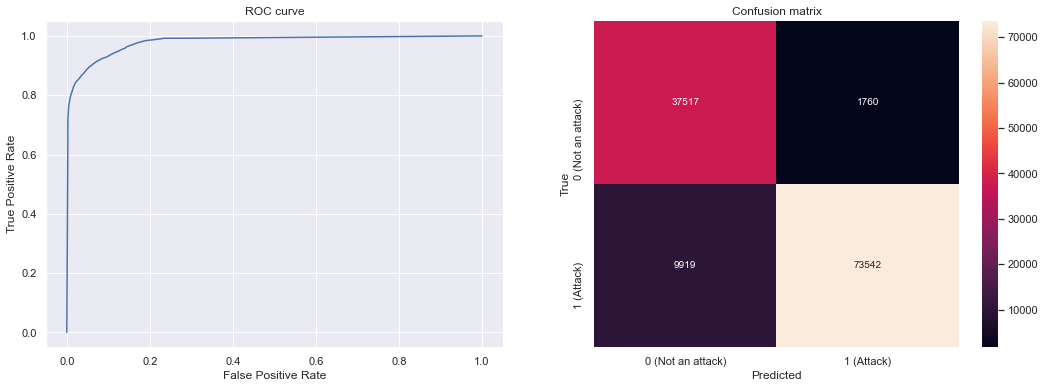

accuracy=0.9048460949339243
recall=0.8811540719617545
f1=0.9264375200770961


In [238]:
rf_clf.fit(X_train, y_train)
print("fitted")
y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

fitted


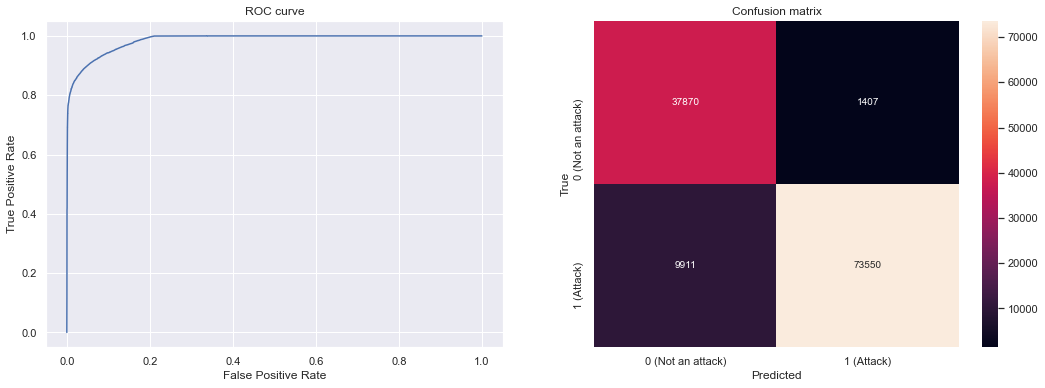

accuracy=0.9077873193306066
recall=0.8812499251147242
f1=0.9285560984231589


In [252]:
xgb_clf.fit(X_train, y_train)
print("fitted")
y_pred = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

fitted


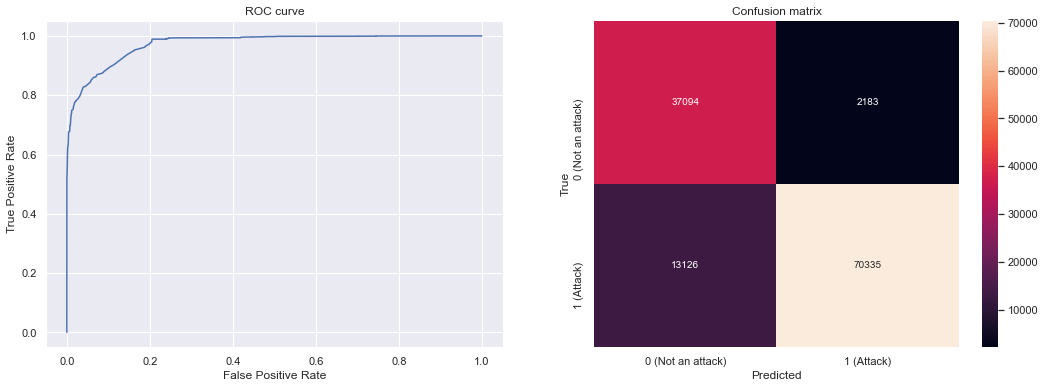

accuracy=0.8752709022470628
recall=0.842728939265046
f1=0.9018521724078241


In [251]:
adb_clf.fit(X_train, y_train)
print("fitted")
y_pred = adb_clf.predict(X_val)
y_pred_proba = adb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

fitted


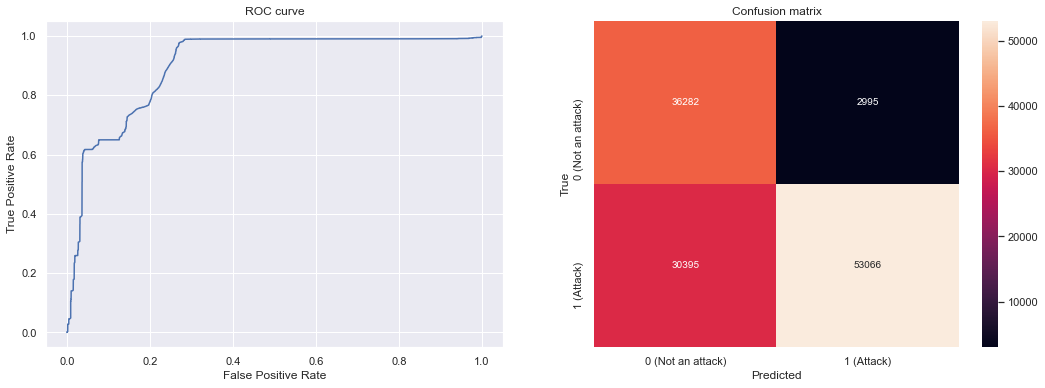

accuracy=0.727957111896886
recall=0.6358179269359342
f1=0.7606829030547154


In [250]:
lr_clf.fit(X_train, y_train)
print("fitted")
y_pred = lr_clf.predict(X_val)
y_pred_proba = lr_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

#### 4. Wnioski Końcowe

Najlepiej z niewielką przewagą sprawuje się XGBClassifier